#Zadanie 4 (7 pkt)
Celem zadania jest zaimplementowanie algorytmu drzewa decyzyjnego ID3 dla zadania klasyfikacji. Trening i test należy przeprowadzić dla zbioru Iris. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania drzewa dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Implementacja funkcji entropii - **0.5 pkt**
* Implementacja funkcji entropii zbioru - **0.5 pkt**
* Implementacja funkcji information gain - **0.5 pkt**
* Zbudowanie poprawnie działającego drzewa klasyfikacyjnego i przetestowanie go na wspomnianym wcześniej zbiorze testowym. Jeśli w liściu występuje kilka różnych klas, decyzją jest klasa większościowa. Policzenie accuracy i wypisanie parami klasy rzeczywistej i predykcji. - **4 pkt**
* Przeprowadzenie eksperymentów dla różnych głębokości drzew i podziałów zbioru treningowego i testowego (zmiana wartości argumentu test_size oraz usunięcie random_state). W tym przypadku dla każdego eksperymentu należy wykonać kilka uruchomień programu i wypisać dla każdego uruchomienia accuracy. - **1.5 pkt**

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt


iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

In [3]:
class Group:
    def __init__(self, group_classes: np.ndarray):
        self.group_classes: np.ndarray = group_classes
        self.entropy = self.group_entropy()
        self.size = group_classes.size

    def __len__(self):
        return self.group_classes.size

    def group_entropy(self):
        sigma = 0
        for g_class in np.unique(self.group_classes):
            frequency = sum(self.group_classes == g_class)/len(self)
            sigma -= frequency * math.log(frequency)
        return sigma



class Node:
    def __init__(self, split_feature, split_val, depth=None, child_node_a=None, child_node_b=None, val=None):
        self.split_feature = split_feature
        self.split_val = split_val
        self.depth = depth
        self.child_node_a: Node = child_node_a
        self.child_node_b: Node = child_node_b
        self.val = val

    def predict(self, data):
        if self.child_node_a is None and self.child_node_b is None:
            return self.val

        if data[self.split_feature] < self.split_val:
            return self.child_node_a.predict(data)

        return self.child_node_b.predict(data)



class DecisionTreeClassifier(object):
    def __init__(self, max_depth):
        self.depth = 0
        self.max_depth = max_depth
        self.tree = None

    def get_information_gain(self, parent_group: Group, child_group_a: Group, child_group_b: Group): # infGain
        entropyA = child_group_a.entropy
        entropyB = child_group_b.entropy
        weightA = child_group_a.size/parent_group.size
        weightB = child_group_b.size/parent_group.size
        return parent_group.entropy - (weightA * entropyA + weightB * entropyB)

    def get_best_feature_split(self, feature_values, classes):
        max_inf_gain = best_split = 0
        for feature in feature_values:
            groupA = Group(classes[feature_values<feature])
            groupB = Group(classes[feature_values>=feature])
            inf_gain = self.get_information_gain(Group(classes), groupA, groupB)
            if inf_gain > max_inf_gain:
                max_inf_gain = inf_gain
                best_split = feature
        return max_inf_gain, best_split



    def get_best_split(self, data, classes):
        max_feature = best_index = best_split = 0
        best_index = None
        for index in range(len(data[0])):
            feature_values = data[:, index]
            feature, split = self.get_best_feature_split(feature_values, classes)
            if feature > max_feature:
                max_feature = feature
                best_index = index
                best_split = split
        return max_feature, best_index, best_split

    def build_tree(self, data, classes, depth=0):
        if len(set(classes)) == 1 or depth == self.max_depth:
            data = Counter(classes)

            return Node(None, None, depth, None, None, data.most_common(1)[0][0])

        _, index, split = self.get_best_split(data, classes)
        if index == None:
            data = Counter(classes)
            return Node(None, None, depth, None, None, data.most_common(1)[0][0])

        left_cond = data[:,index] < split
        right_cond = data[:,index] >= split
        left_data, left_classes = data[left_cond], classes[left_cond]
        right_data, right_classes = data[right_cond], classes[right_cond]

        childA = self.build_tree(left_data, left_classes, depth+1)
        childB = self.build_tree(right_data, right_classes, depth+1)


        parent = Node(index, split, depth, childA, childB, None)
        if depth == 0:

            self.tree = parent
        return parent

    def predict(self, data):
        return self.tree.predict(data)

In [4]:
def build_and_print(depth, test_size, v = 1):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    dc = DecisionTreeClassifier(depth)
    dc.build_tree(x_train, y_train)
    res = 0
    for sample, gt in zip(x_test, y_test):
        prediction = dc.predict(sample)
        if prediction == gt:
            res +=1
    res = res/len(y_test)
    if v:
        print(f'Result = {res:.2};\twhere depth = {depth},\ttest size = {test_size}')
    return res


# depth = 1


In [19]:
for _ in range(4):
    build_and_print(1,0.1)

Result = 0.47;	where depth = 1,	test size = 0.1
Result = 0.6;	where depth = 1,	test size = 0.1
Result = 0.53;	where depth = 1,	test size = 0.1
Result = 0.73;	where depth = 1,	test size = 0.1


In [6]:
for _ in range(4):
    build_and_print(1, 0.5)

Result = 0.61;	where depth = 1,	test size = 0.5
Result = 0.63;	where depth = 1,	test size = 0.5
Result = 0.69;	where depth = 1,	test size = 0.5
Result = 0.64;	where depth = 1,	test size = 0.5


In [7]:
for _ in range(4):
    build_and_print(1, 0.8)

Result = 0.64;	where depth = 1,	test size = 0.8
Result = 0.59;	where depth = 1,	test size = 0.8
Result = 0.66;	where depth = 1,	test size = 0.8
Result = 0.66;	where depth = 1,	test size = 0.8


# depth = 2

In [8]:
for _ in range(4):
    build_and_print(2, 0.1)

Result = 0.93;	where depth = 2,	test size = 0.1
Result = 0.93;	where depth = 2,	test size = 0.1
Result = 1.0;	where depth = 2,	test size = 0.1
Result = 0.93;	where depth = 2,	test size = 0.1


In [9]:
for _ in range(4):
    build_and_print(2, 0.5)

Result = 0.95;	where depth = 2,	test size = 0.5
Result = 0.95;	where depth = 2,	test size = 0.5
Result = 0.91;	where depth = 2,	test size = 0.5
Result = 0.93;	where depth = 2,	test size = 0.5


In [10]:
for _ in range(4):
    build_and_print(2, 0.8)

Result = 0.94;	where depth = 2,	test size = 0.8
Result = 0.94;	where depth = 2,	test size = 0.8
Result = 0.82;	where depth = 2,	test size = 0.8
Result = 0.94;	where depth = 2,	test size = 0.8


# depth = 3

In [11]:
for _ in range(4):
    build_and_print(3, 0.1)

Result = 0.93;	where depth = 3,	test size = 0.1
Result = 1.0;	where depth = 3,	test size = 0.1
Result = 0.87;	where depth = 3,	test size = 0.1
Result = 1.0;	where depth = 3,	test size = 0.1


In [12]:
for _ in range(4):
    build_and_print(3, 0.5)

Result = 0.99;	where depth = 3,	test size = 0.5
Result = 0.95;	where depth = 3,	test size = 0.5
Result = 0.95;	where depth = 3,	test size = 0.5
Result = 0.92;	where depth = 3,	test size = 0.5


In [13]:
for _ in range(4):
    build_and_print(3, 0.8)

Result = 0.94;	where depth = 3,	test size = 0.8
Result = 0.95;	where depth = 3,	test size = 0.8
Result = 0.94;	where depth = 3,	test size = 0.8
Result = 0.95;	where depth = 3,	test size = 0.8


In [14]:
for _ in range(4):
    build_and_print(4, 0.8)

Result = 0.91;	where depth = 4,	test size = 0.8
Result = 0.82;	where depth = 4,	test size = 0.8
Result = 0.97;	where depth = 4,	test size = 0.8
Result = 0.96;	where depth = 4,	test size = 0.8


In [15]:
for _ in range(4):
    build_and_print(5, 0.8)

Result = 0.94;	where depth = 5,	test size = 0.8
Result = 0.93;	where depth = 5,	test size = 0.8
Result = 0.9;	where depth = 5,	test size = 0.8
Result = 0.97;	where depth = 5,	test size = 0.8


# normal test from exercise

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

dc = DecisionTreeClassifier(3)
dc.build_tree(x_train, y_train)
res = 0
for sample, gt in zip(x_test, y_test):

    prediction = dc.predict(sample)
    print(f'Prediction = {prediction}, real value = {gt}')
    if prediction == gt:
        res +=1
print(res/len(y_test))


Prediction = 2, real value = 1
Prediction = 2, real value = 2
Prediction = 2, real value = 2
Prediction = 1, real value = 1
Prediction = 0, real value = 0
Prediction = 2, real value = 2
Prediction = 1, real value = 1
Prediction = 0, real value = 0
Prediction = 0, real value = 0
Prediction = 1, real value = 1
Prediction = 2, real value = 2
Prediction = 0, real value = 0
Prediction = 1, real value = 1
Prediction = 2, real value = 2
Prediction = 2, real value = 2
0.9333333333333333


# plots depth 1 to 5

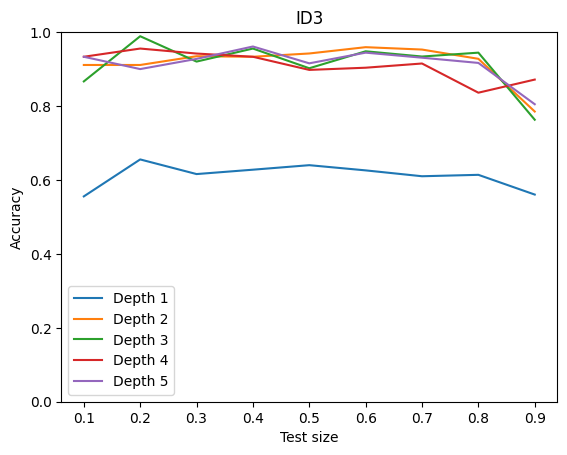

In [28]:

x_values = np.arange(0.1, 1.0, 0.1)


DEPTH = 5
REPS = 3

y_values_list =  [[] for _ in range(DEPTH)]

for depth in range(1, DEPTH+1):
    for test_size in x_values:
        res = 0
        for _ in range(REPS):
            res += build_and_print(depth, test_size, 0)
        res /= REPS
        y_values_list[depth-1].append(res)


for depth, y_values in enumerate(y_values_list):
    plt.plot(x_values, y_values, label=f'Depth {depth+1}')


plt.xlabel('Test size')
plt.ylabel('Accuracy')
plt.title('ID3')

plt.legend()
plt.ylim(0, 1)
plt.show()

# plots depth 10 to 50, step 10

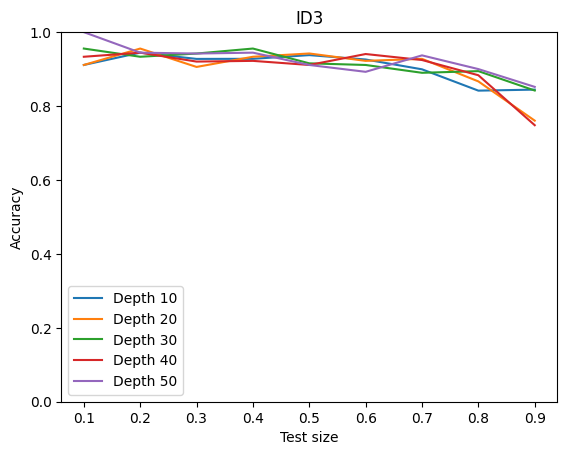

In [27]:
x_values = np.arange(0.1, 1.0, 0.1)

DEPTH = 5
REPS = 3

y_values_list =  [[] for _ in range(DEPTH)]

for depth in range(1, DEPTH+1):
    for test_size in x_values:
        res = 0
        for _ in range(REPS):
            res += build_and_print(depth*10, test_size, 0)
        res /= REPS
        y_values_list[depth-1].append(res)


for depth, y_values in enumerate(y_values_list):
    plt.plot(x_values, y_values, label=f'Depth {(depth+1)*10}')

plt.xlabel('Test size')
plt.ylabel('Accuracy')
plt.title('ID3')
plt.ylim(0, 1)
plt.legend()

plt.show()